# <center> Machine Learning Project: Car Brand Recognition </center>


* [**1. Introduction**](#ch1)
  * [1.1 Choix du sujet et objectif du projet](#ch1.1)
  * [1.2 Collecte des données](#ch1.2)
  
* [**2. Modèle de classification binaire**](#ch2)
  * [2.1 Définition du modèle et prédiction](#ch2.1)
  * [2.2 Etude des kernels](#ch2.2)
    * [2.2.1 Méthode "expérimentale"](#ch2.2.1)
    * [2.2.2 Méthode avec "activation map"](#ch2.2.2)
* [**3 Modèle de classification "Softmax"**](#ch3)

* [**4. Conclusion**](#ch3)

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing import image
import keras.backend as K
from keras import models
import cv2
import os
import seaborn as sns
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout

<a id="ch1"></a>

## 1. Introduction

<a id="ch1.1"></a>
### 1.1 Choice of subject and project objectives
Both passionate about cars, over the summer we had the idea of creating a “Shazam for cars,” similar to the well-known app that recognizes music by recording a short snippet. Because when you see a car on the street, it's not always easy to identify it. This semester, we had to think of a topic for our machine learning project. So it was only natural that we decided to focus on car recognition. Of course, it will be a simplified version to match the knowledge we have acquired since January in machine learning.  \
The objective is for our algorithm to distinguish between several brands based on a photograph of a given car.

<a id="ch1.2"></a>
### 1.2 Data Collection

Due to a lack of data on the internet, we decided to create our own samples. To start with, for our first model, we took photos of Peugeot and Renault vehicles from the front as they drove down the street. We chose these brands for practical reasons, as they are the most common brands in France. \\
We quickly realized that this was too time-consuming. So we expanded the samples by taking screenshots of cars for sale on the website *lacentrale.fr*. \\
For the second model, we kept the two brands Peugeot and Renault, but we added an “others” class where we put photos of various brands (BMW, Audi, Mercedes, Citroën, and Volkswagen), most of which also came from the website *lacentrale.fr*.
In total, we were able to obtain about 1,600 photos, distributed evenly.
The photos were then modified to make them square and to reduce their size to 512x512 pixels.

<a id="ch2"></a>

## 2. Binary classification model

We take 80% of the sample for training and 20% for validation.

In [2]:
data_directory = "../data/2brands"
image_size = (512, 512)
batch_size = 16
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_directory,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_directory,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 1043 files belonging to 2 classes.
Using 835 files for training.
Found 1043 files belonging to 2 classes.
Using 208 files for validation.


Below, you can see examples of images used for training.

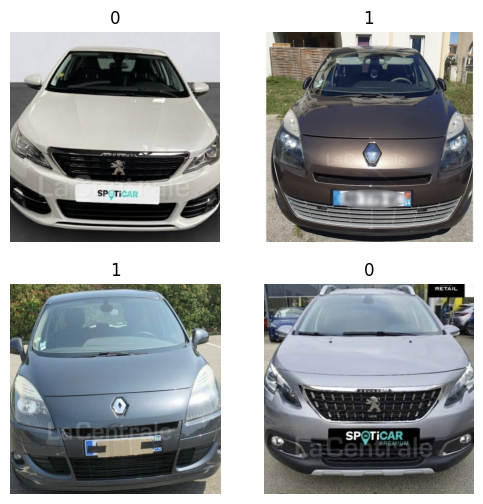

In [7]:
plt.figure(figsize=(6,6))
for images, labels in train_ds.take(1):
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

To increase the sample size and diversify it, we performed preprocessing that induces random rotation of the images. \
This increases realism because a photo taken by someone is never perfectly straight.

In [11]:
data_augmentation = keras.Sequential([
        layers.RandomRotation(0.05),
        #layers.experimental.preprocessing.RandomZoom(.5, .2)
        ])

Below, you can see the effect of preprocessing on an image.

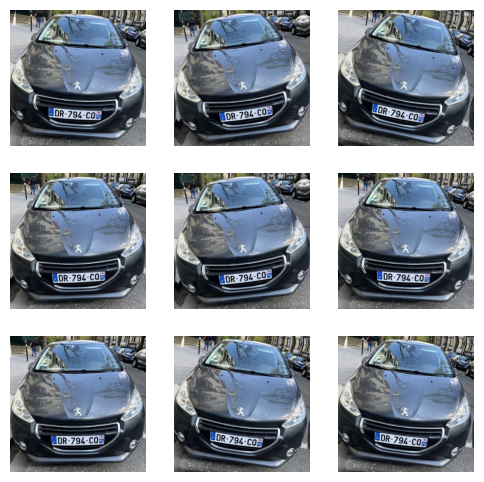

In [13]:
plt.figure(figsize=(6, 6))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

We have built a model that is a neural network. It is based on a sequence of convolutions and max poolings.

In [14]:
def make_model(input_shape,num_classes):
  inputs = keras.Input(shape=input_shape)
  x = data_augmentation(inputs)
  #x = inputs
  x = layers.Rescaling(1./255)(x)

  x = Conv2D(16,3,padding='same',input_shape=(512,512,3),activation='relu')(x)
  x = MaxPool2D((2, 2))(x)
  x = Conv2D(32,3,padding='same',activation='relu')(x)
  x = MaxPool2D((2, 2))(x)
  x = Conv2D(64,3,padding='same',activation='relu')(x)
  x = MaxPool2D((2, 2))(x)
  x = Conv2D(128,3,padding='same',activation='relu')(x)
  x = MaxPool2D((2, 2))(x)
  x = Flatten()(x)
  outputs = Dense(1,activation='sigmoid')(x)
  return keras.Model(inputs, outputs)
model = make_model(input_shape=image_size + (3,), num_classes=2)
model.summary()
weights = model.get_weights()

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 512, 512, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 512, 512, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 512, 512, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 512, 512, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 256, 256, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │       131,073 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 228,513 (892.63 KB)

 Trainable params: 228,513 (892.63 KB)

 Non-trainable params: 0 (0.00 B)

We noticed that 30 epochs was satisfactory. Indeed, after decreasing, the training loss curve reaches a plateau as expected. In addition, the validation loss curve follows that of the training loss.

In [ ]:
epochs = 30

callbacks = [
    keras.callbacks.ModelCheckpoint("save_best.h5",save_best_only=True,),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
history=model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

In [ ]:
plt.plot(history.history['loss'],label='training')
plt.plot(history.history['val_loss'],label='validation')
plt.title('Graph showing loss as a function of epochs (2 classes)')
plt.xlabel('epochs'); plt.ylabel('loss'); plt.legend()

During our initial tests, we did not use preprocessing. We were not obtaining satisfactory curves: the validation loss deviated too much from the training loss. Below is the loss curve for this model:

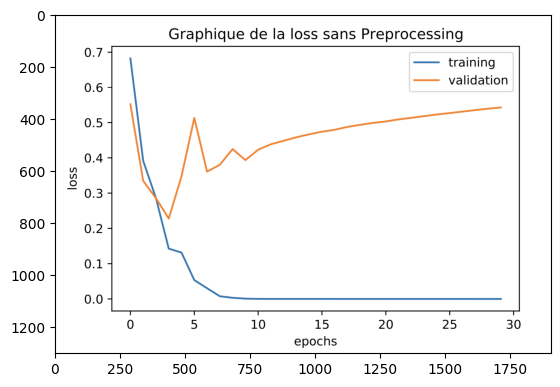

In [17]:
image2=mpimg.imread("../data/graphs/noPreprocessing.png")
plt.imshow(image2)

We extract the best epoch.

In [18]:
model.load_weights("save_best.h5")

We define a function that tests the model for an image of our choice and predicts which brand the car in the image belongs to, along with the algorithm's confidence level.

In [28]:
def predict2brands(path_image):
  image=mpimg.imread(path_image)
  plt.imshow(image)
  img = keras.preprocessing.image.load_img(
    path_image, target_size=image_size
  )
  img_array = keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)  # Create batch axis

  predictions = model.predict(img_array)
  score = predictions[0][0]
  print(
    "This image is %.2f percent Peugeot and %.2f percent Renault."
    % (100 * (1 - score), 100 * score)
)

Here is an example with an image from the *tests* folder. You can try with any other image from this folder or from the internet, provided that it is taken from the front and is 512x512 pixels.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
This image is 99.78 percent Peugeot and 0.22 percent Renault.


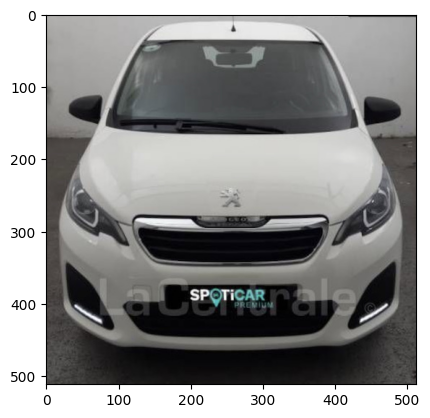

In [29]:
predict2brands("../data/tests/P108.jpeg")

The results obtained are very satisfactory. Front-facing images are formally identified with a very high degree of certainty. The algorithm is at least 97% certain of the brand.

### 2.2 Study of the kernels

#### 2.2.1 "Experimental" method

Let's compare the prediction results for a photo in which different elements have been blurred. First, here is the prediction for the reference image, i.e., without blurring.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
This image is 0.00 percent Peugeot and 100.00 percent Renault.


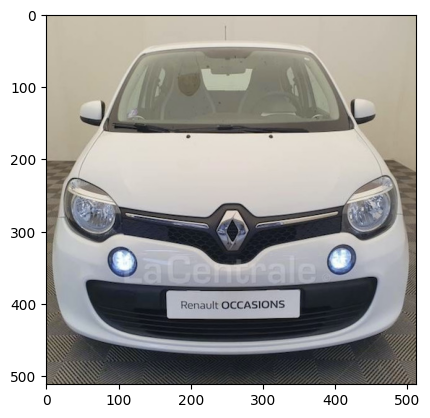

In [30]:
predict2brands("../data/tests/twingoavec.jpeg")

Here is the result when the logo is hidden:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
This image is 0.01 percent Peugeot and 99.99 percent Renault.


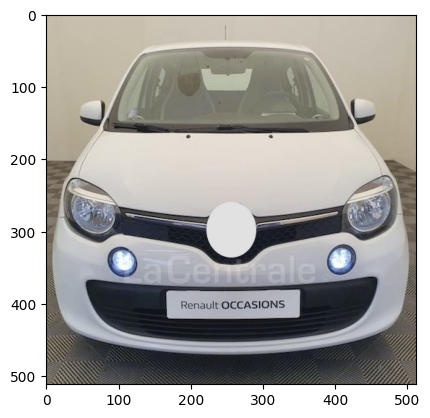

In [31]:
predict2brands("../data/tests/twingosanslogo.jpeg")

Here is the result when the headlights are hidden:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
This image is 0.00 percent Peugeot and 100.00 percent Renault.


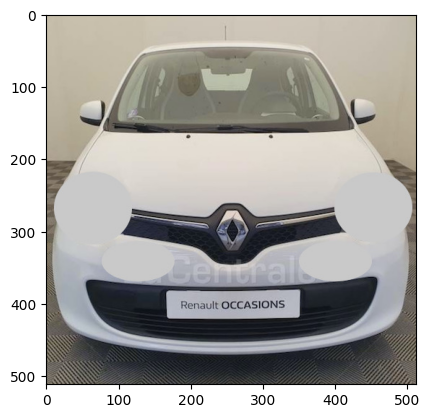

In [32]:
predict2brands("../data/tests/twingosansphares.jpeg")

Voici le résultat lorsqu'on cache les phares et le logo:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
This image is 99.05 percent Peugeot and 0.95 percent Renault.


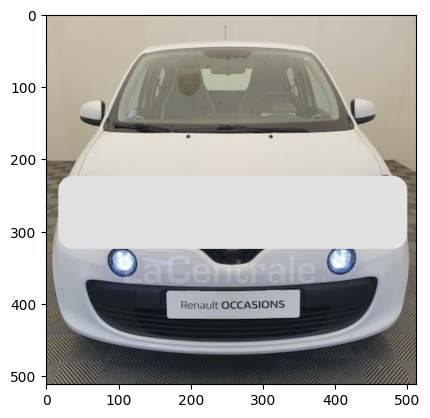

In [33]:
predict2brands("../data/tests/twingosansavant.jpeg")

We can see that if we remove either the logo or the headlights, the prediction remains virtually unchanged from the reference image. However, if we hide both the logo and the headlights, the algorithm makes a mistake. This is because a Twingo without a logo or headlights resembles a Peugeot 108 in terms of its proportions.

#### 2.2.2 Model with "activation map"

We define the following two functions that display the weight of each pixel during the last convolution layer.

In [55]:
def get_output_layer(model, layer_name):
    layer_dict = dict([(layer.name, layer) for layer in model.layers])
    layer = layer_dict[layer_name]
    return layer

def visualize_class_activation_map(model_path, img_path, output_path):
        model = models.load_model(model_path)
        original_img = cv2.imread(img_path, 1)
        width, height, _ = original_img.shape
        img = np.array([np.transpose(np.float32(original_img), (0, 1, 2))])
        class_weights = model.layers[-1].get_weights()[0]
        layer_name=model.layers[-3].name
        final_conv_layer = get_output_layer(model, layer_name)
        get_output = keras.Model(
            inputs=model.input,
            outputs=[final_conv_layer.output, model.layers[-1].output]
        )
        conv_outputs, predictions = get_output(img, training=False)
        conv_outputs = conv_outputs.numpy()[0]
        predictions  = predictions.numpy()[0]
        #Activation map creation
        cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[0:2])
        target_class = 1
        conv_outputs=conv_outputs.reshape(32*32*128,1)
        cam2=conv_outputs*class_weights
        cam2=cam2.reshape(32*32,128)
        cam3=np.sum(cam2,axis=1)
        cam=cam3.reshape(32,32)
        plt.imshow(cam,cmap='viridis')
        plt.title("activation map during the last convolutional layer")

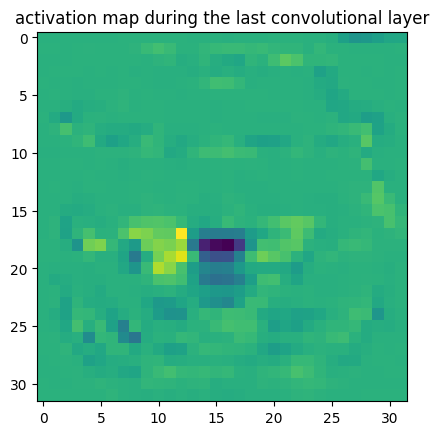

In [58]:
visualize_class_activation_map('save_best.h5', '../data/tests/P108.jpeg', '../data/activations')

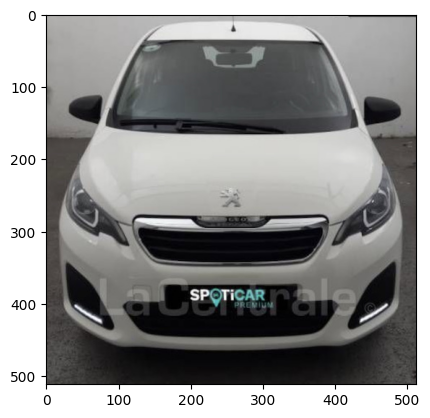

In [59]:
image=mpimg.imread("../data/tests/P108.jpeg")
plt.imshow(image)

We note that the result obtained using this method matches that obtained using our experimental method. Indeed, we see that the combination of the grille, lights, and logo is what the kernels focus on to identify the vehicle.